In [1]:
import gym
env = gym.make('Blackjack-v0')

In [2]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [4]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((17, 4, False), 1, -1)]
[((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[((9, 5, False), 1, 0), ((18, 5, False), 1, -1)]


In [144]:
from collections import defaultdict
import numpy as np
import sys

# This is every visit MC method for estimating state values.
def every_visit_mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
# Initialize empty dictionaries of arrays.
    returns_sum = defaultdict(lambda: 0)
# Use the following returns_sum if you are uncommenting the last section.
#     returns_sum = defaultdict(list)
    N = defaultdict(lambda: 0)
    V = {}
    # Loop over episodes.
    for i_episode in range(1, num_episodes+1):
        # Monitor progress.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate an episode.
        episode = generate_episode_from_limit(env)
        # Get states, actions and rewards from the episode.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discount_multiplyer = np.array([gamma**i for i in range(len(actions)+1)])
        # Calculate and store the return for each visit in the episode.
        for i, state in enumerate(states):
            returns_sum[state] += sum(rewards[i:]*discount_multiplyer[:-(i+1)])
            N[state] += 1.0
            # Calculate the state-value function estimate.
            V[state] =  returns_sum[state]/N[state]
# Some other implementations for estimating the state-value function. To use this instead, uncomment the 
# following section below and comment the above three lines.
#             returns_sum[state].append(sum(rewards[i:]*discount_multiplyer[:-(i+1)]))
#     V = {k:(sum(v)/N[k]) for k, v in returns_sum.items()}
#                       or(uncomment any one of the two )
#     V = {k:np.mean(v) for k, v in returns_sum.items()}
    return V

In [145]:
from collections import defaultdict
import numpy as np
import sys

# This is first visit MC method for estimating state values.
def first_visit_mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays.
    returns_sum = defaultdict(lambda: 0)
# Use the following returns_sum if you are uncommenting the last section.
#     returns_sum = defaultdict(list)
    N = defaultdict(lambda: 0)
    V = {}
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # To check for first visit of state in an episode.
        visited = defaultdict(lambda: False)
        # Generate an episode.
        episode = generate_episode_from_limit(env)
        # Get states, actions and rewards from the episode.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discount_multiplyer = np.array([gamma**i for i in range(len(actions)+1)])
        # Calculate and store the return for each visit in the episode.
        for i, state in enumerate(states):
            if visited[state] == False:
                returns_sum[state] += sum(rewards[i:]*discount_multiplyer[:-(i+1)])
                N[state] += 1.0
                # Calculate the state-value function estimate.
                V[state] =  returns_sum[state]/N[state]
# Some other implementations for estimating the state-value function. To use this instead, uncomment the 
# following section below and comment the above three lines.
#                 returns_sum[state].append(sum(rewards[i:]*discount_multiplyer[:-(i+1)]))
#     V = {k:(sum(v)/N[k]) for k, v in returns_sum.items()}
#                       or(uncomment any one of the two )
#     V = {k:np.mean(v) for k, v in returns_sum.items()}
    return V

Episode 500000/500000.

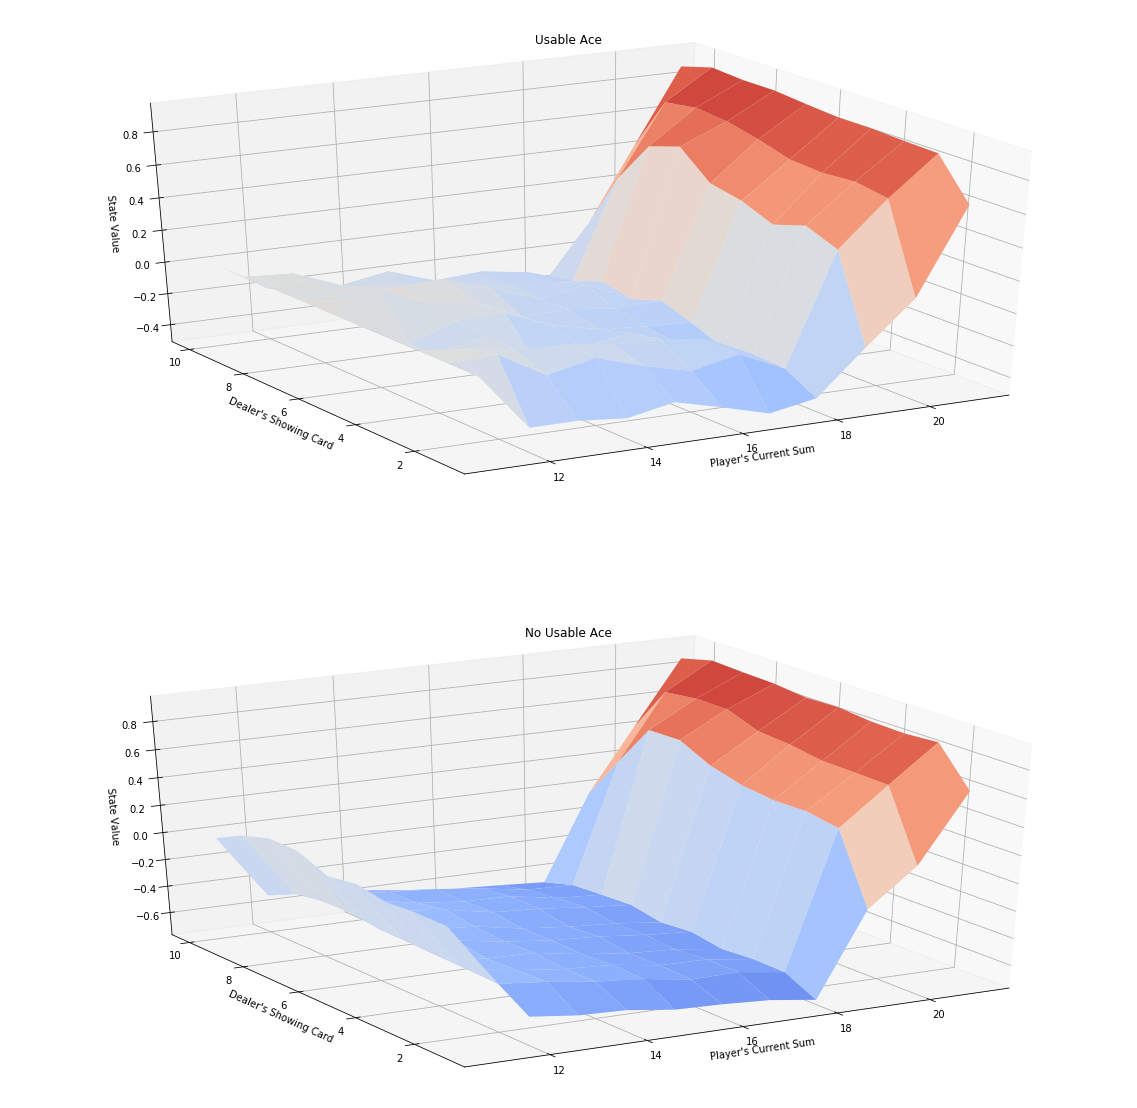

In [159]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = every_visit_mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

In [135]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0]<18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [153]:
# This is every visit MC method for estimating the action value function.
def every_visit_mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays.
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Loop over episodes.
    for i_episode in range(1, num_episodes+1):
        # Monitor progress.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate an episode.
        episode = generate_episode(env)
        # Get states, actions and rewards from the episode.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # Update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode.
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(i+1)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]]/N[state][actions[i]]
    return Q

In [154]:
# This is first visit MC method for estimating the action value function.
def first_visit_mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # To check for first visit of state, action pair in an episode.
        visited = defaultdict(lambda: np.full(shape=env.action_space.n, fill_value = False))
        # Generate an episode.
        episode = generate_episode(env)
        # Obtain states, actions, and rewards.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # Update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode.
        for i, state in enumerate(states):
            if visited[state][actions[i]] == False: 
                returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
                N[state][actions[i]] += 1.0
                Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Episode 500000/500000.

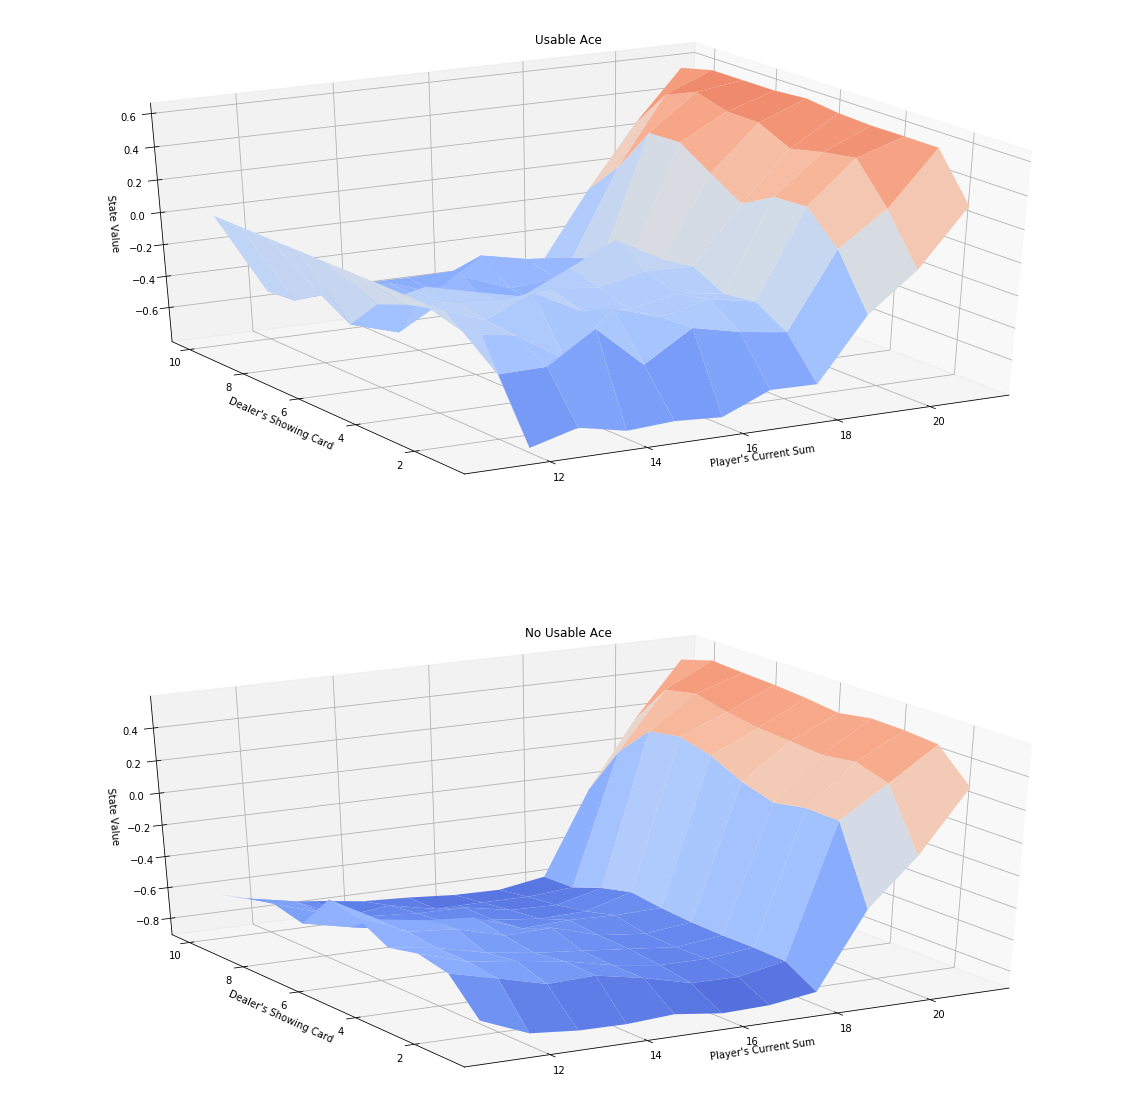

In [160]:
# obtain the action-value function
Q = first_visit_mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)